In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import nibabel as nb
import scipy as sp
import matplotlib.pyplot as pl
import os
opj = os.path.join
%matplotlib notebook
pl.ion()

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, Norm_Iso2DGaussianGridder, DoG_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter
from prfpy.timecourse import sgfilter_predictions
from utils.utils import *
from prfpy.fit import iterative_search

Using TensorFlow backend.


In [3]:
#some params needed (stimulus size, initial volumes to discard, savgol window length)
n_pix=40
discard_volumes = 5
window_length=121

In [4]:
#create stimulus
dm_1R = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-1R_run-1_Logs/Screenshots', n_pix=n_pix)
dm_1S = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-1S_run-1_Logs/Screenshots', n_pix=n_pix)
dm_2R = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-2R_run-1_Logs/Screenshots', n_pix=n_pix)
dm_4F = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-4F_run-1_Logs/Screenshots', n_pix=n_pix)
dm_4R = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-4R_run-1_Logs/Screenshots', n_pix=n_pix)

task_lengths=[dm_1R.shape[2]-discard_volumes, 
              dm_1S.shape[2]-discard_volumes, 
              dm_2R.shape[2]-discard_volumes, 
              dm_4F.shape[2]-discard_volumes, 
              dm_4R.shape[2]-discard_volumes]

dm_full = np.concatenate((dm_1R[:,:,discard_volumes:],
                          dm_1S[:,:,discard_volumes:],
                          dm_2R[:,:,discard_volumes:],
                          dm_4F[:,:,discard_volumes:],
                          dm_4R[:,:,discard_volumes:]), axis=-1)

prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=210, 
                         design_matrix=dm_full,
                         TR=1.5)

In [4]:
#calculating the average BOLD baseline so that it is the same throughout the timecourse (BOLD has arbtirary units)
iso_periods = np.where(np.sum(dm_full, axis=(0,1))==0)[0]
shifted_dm = np.zeros_like(dm_full)
#number of TRs in which activity may linger (hrf)
shifted_dm[:,:,7:] = dm_full[:,:,:-7]

late_iso_periods = np.where((np.sum(dm_full, axis=(0,1))==0) & (np.sum(shifted_dm, axis=(0,1))==0))[0]

late_iso_dict={}
late_iso_dict['1R'] = np.split(late_iso_periods,5)[0]
late_iso_dict['1S'] = np.split(late_iso_periods,5)[1]
late_iso_dict['2R'] = np.split(late_iso_periods,5)[2]
late_iso_dict['4F'] = np.split(late_iso_periods,5)[3]
late_iso_dict['4R'] = np.split(late_iso_periods,5)[4]

In [58]:
################preparing the data (SURFACE FITTING)
data_path = '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-noflairtse-manual-hires'
subj = 'sub-001'
tc_dict = {}
tc_full_iso_nonzerovar_dict = {}
for hemi in ['L', 'R']:
    tc_dict[hemi] = {}
    for task_name in ['1R', '1S', '2R', '4F', '4R']:
        data_ses1 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-1/func/'+subj+'_ses-1_task-'+task_name+'_run-1_space-fsaverage_hemi-'+hemi+'.func.gii'))
        data_ses2 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-2/func/'+subj+'_ses-2_task-'+task_name+'_run-1_space-fsaverage_hemi-'+hemi+'.func.gii'))
               
        tc_ses_1 = sgfilter_predictions(np.array([arr.data for arr in data_ses1.darrays]).T[...,discard_volumes:],
                                         window_length=window_length)

        tc_ses_2 = sgfilter_predictions(np.array([arr.data for arr in data_ses2.darrays]).T[...,discard_volumes:],
                                         window_length=window_length)

        tc_dict[hemi][task_name] = (tc_ses_1+tc_ses_2)/2.0
    
    print('Finished filtering hemi '+hemi)
    #when scanning sub-001 i mistakenly set the length of the 4F scan to 147, while it should have been 145
    #therefore, there are two extra images at the end to discard in that time series.
    #from sub-002 onwards, this was corrected.
    if subj == 'sub-001':
        tc_dict[hemi]['4F'] = tc_dict[hemi]['4F'][...,:-2]
        
    tc_full=np.concatenate((tc_dict[hemi]['1R'],
                            tc_dict[hemi]['1S'],
                            tc_dict[hemi]['2R'],
                            tc_dict[hemi]['4F'],
                            tc_dict[hemi]['4R']), axis=-1)
    
    
    #shift timeseries so they have the same average value in proper baseline periods across conditions
    iso_full = np.mean(tc_full[...,late_iso_periods], axis=-1)
    iso_1R_diff = iso_full - np.mean(tc_full[...,late_iso_dict['1R']], axis=-1)
    iso_1S_diff = iso_full - np.mean(tc_full[...,late_iso_dict['1S']], axis=-1)
    iso_2R_diff = iso_full - np.mean(tc_full[...,late_iso_dict['2R']], axis=-1)
    iso_4F_diff = iso_full - np.mean(tc_full[...,late_iso_dict['4F']], axis=-1)
    iso_4R_diff = iso_full - np.mean(tc_full[...,late_iso_dict['4R']], axis=-1)
       
    tc_full_iso=np.concatenate((tc_dict[hemi]['1R'] + iso_1R_diff[...,np.newaxis],
                                tc_dict[hemi]['1S'] + iso_1S_diff[...,np.newaxis],
                                tc_dict[hemi]['2R'] + iso_2R_diff[...,np.newaxis],
                                tc_dict[hemi]['4F'] + iso_4F_diff[...,np.newaxis],
                                tc_dict[hemi]['4R'] + iso_4R_diff[...,np.newaxis]), axis=-1)
    
    
    tc_full_iso_nonzerovar_dict['indices_'+hemi] = np.where(np.var(tc_full_iso, axis=-1)>0)
    tc_full_iso_nonzerovar_dict['tc_'+hemi] = tc_full_iso[np.where(np.var(tc_full_iso, axis=-1)>0)]
    
    
    
        
        

Finished filtering hemi L
Finished filtering hemi R


In [44]:
#############preparing the data (VOLUME FITTING)
############VOLUME MASK
data_path = '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-noflairtse-manual-hires'
subj = 'sub-001'

#create a single brain mask in epi space 
mask_dict = {}
for task_name in ['1R', '1S', '2R', '4F', '4R']:
    mask_ses_1 = nb.load(opj(data_path,'fmriprep/'+subj+'/ses-1/func/'+subj+'_ses-1_task-'+task_name+'_run-1_space-T1w_desc-brain_mask.nii.gz')).get_data().astype(bool)
    mask_ses_2 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-2/func/'+subj+'_ses-2_task-'+task_name+'_run-1_space-T1w_desc-brain_mask.nii.gz')).get_data().astype(bool)
    
    mask_dict[task_name] = mask_ses_1 & mask_ses_2
    
final_mask = mask_dict['1R'] & mask_dict['1S'] & mask_dict['2R'] & mask_dict['4F'] & mask_dict['4R']


In [7]:
#############preparing the data (VOLUME FITTING)
tc_dict = {}
for task_name in ['1R', '1S', '2R', '4F', '4R']:
    timecoursefile_ses_1 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-1/func/'+subj+'_ses-1_task-'+task_name+'_run-1_space-T1w_desc-preproc_bold.nii.gz'))
    timecoursefile_ses_2 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-2/func/'+subj+'_ses-2_task-'+task_name+'_run-1_space-T1w_desc-preproc_bold.nii.gz'))
       
    tc_ses_1 = sgfilter_predictions(timecoursefile_ses_1.get_data()[...,discard_volumes:],
                                            window_length=window_length)
    tc_ses_2 = sgfilter_predictions(timecoursefile_ses_2.get_data()[...,discard_volumes:],
                                            window_length=window_length)
        
    tc_dict[task_name] = (tc_ses_1+tc_ses_2)/2.0
    
    
    
               

#when scanning sub-001 i mistakenly set the length of the 4F-task scan to 147, while it should have been 145
#therefore, there are two extra images at the end to discard in that time series.
#from sub-002 onwards, this was corrected.
if subj == 'sub-001':
    tc_dict['4F'] = tc_dict['4F'][...,:-2]
    

timecourse_full=np.concatenate((tc_dict['1R'],
                                tc_dict['1S'],
                                tc_dict['2R'],
                                tc_dict['4F'],
                                tc_dict['4R']), axis=-1)


#shift timeseries so they have the same average value in baseline periods across conditions
iso_full = np.mean(timecourse_full[...,late_iso_periods], axis=-1)
iso_1R_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['1R']], axis=-1)
iso_1S_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['1S']], axis=-1)
iso_2R_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['2R']], axis=-1)
iso_4F_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['4F']], axis=-1)
iso_4R_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['4R']], axis=-1)


timecourse_full_iso=np.concatenate((tc_dict['1R'] + iso_1R_diff[...,np.newaxis],
                                    tc_dict['1S'] + iso_1S_diff[...,np.newaxis],
                                    tc_dict['2R'] + iso_2R_diff[...,np.newaxis],
                                    tc_dict['4F'] + iso_4F_diff[...,np.newaxis],
                                    tc_dict['4R'] + iso_4R_diff[...,np.newaxis]), axis=-1)

                  
#brain mask                  
timecourse_brain = timecourse_full_iso[final_mask]
#exclude timecourses with zero variance
timecourse_brain_nonzerovar = timecourse_brain[np.where(np.var(timecourse_brain, axis=-1)>0)]

In [5]:
#np.save('/Users/marcoaqil/PRFMapping/timecourse_brain_nonzerovar_sub-001.npy', timecourse_brain_nonzerovar)
timecourse_brain_nonzerovar = np.load('/Users/marcoaqil/PRFMapping/timecourse_brain_nonzerovar_sub-001.npy')

In [17]:
#create gaussian grid
grid_nr = 20
max_ecc_size = 16
sizes, eccs, polars = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          filter_predictions=True,
                          window_length=window_length,
                          task_lengths=task_lengths)

In [18]:
%%time
gf = Iso2DGaussianFitter(data=timecourse_brain_nonzerovar, gridder=gg, n_jobs=10)

gf.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes)

100%|██████████| 8000/8000 [8:00:42<00:00,  3.56s/it]  

CPU times: user 21h 42min 25s, sys: 2h 49min 11s, total: 1d 31min 37s
Wall time: 8h 49s


In [20]:
np.save('/Users/marcoaqil/PRFMapping/gauss_grid_sub-001.npy', gf.gridsearch_params)

In [19]:
%%time
#refine Gaussian fits
gf.iterative_fit(rsq_threshold=0.1, verbose=True)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  9.7min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 18.6min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 29.3min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 42.8min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 60.7min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 79.5min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 105.7min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 136.5min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 162.9min


CPU times: user 49.2 s, sys: 8.7 s, total: 57.9 s
Wall time: 3h 14min 20s


[Parallel(n_jobs=10)]: Done 5765 out of 5765 | elapsed: 194.3min finished


In [21]:
np.save('/Users/marcoaqil/PRFMapping/gauss_iter_sub-001.npy', gf.iterative_search_params)

In [6]:
gridsearch_params =np.load('/Users/marcoaqil/PRFMapping/gauss_grid_sub-001.npy')

In [30]:
%%time
#now refit normalization model, starting from results of iterated Gaussian fitting
gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                    hrf=[1,1,0],
                                   filter_predictions=True,
                                   window_length=window_length,
                                   task_lengths=task_lengths)
inf=np.inf
eps=1e-4 #to avoid dividing by zero

gf_norm = Norm_Iso2DGaussianFitter(data=timecourse_brain_nonzerovar,
                                   gridder=gg_norm,
                                   n_jobs=10,
                                   bounds=[(-10*n_pix,10*n_pix),  #x
                                           (-10*n_pix,10*n_pix),  #y
                                           (eps,10*n_pix),     #prf size
                                           (-inf,+inf),  #prf amplitude
                                           (0,+inf),     #bold baseline
                                           (0,+inf),     #neural baseline
                                           (0,+inf),     #surround amplitude 
                                           (eps,10*n_pix),     #surround size
                                           (eps,+inf)],        #surround baseline   
                                   gradient_method='numerical')     
                                     

#have to add a column since in current code syntax
#gridsearch_params always contains the CSS exponent parameter, even if it is not fit.
#whereas iterative_search_params does not contain it if it is not fit)
#starting_params = np.insert(gf.iterative_search_params, -1, 1.0, axis=-1)

#starting_params = np.insert(current_result_numerical, -1, 1.0, axis=-1)#gridsearch_params

starting_params = gridsearch_params

gf_norm.iterative_fit(rsq_threshold=0.0, gridsearch_params=starting_params, verbose=True)

current_result_numerical=np.copy(gf_norm.iterative_search_params)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 12.3min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 59.9min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 135.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 240.3min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 376.0min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 540.2min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 738.3min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 958.5min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 1205.8min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 1493.1min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 1807.0min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 2145.0min


KeyboardInterrupt: 

In [10]:
#analytic LBFGSB in 1.1minutes, with tol 1e-80, maxls=300 (best rsq=0.758464 with spm hrf derivative)
print(gridsearch_params[np.where(gridsearch_params[:,-1]>0.1),-1].mean())
print(current_result[np.where(gridsearch_params[:,-1]>0.1),-1].mean())

0.6817100110484308
0.7584493981057998


In [ ]:
#numerical L BFGS B in 3.7min, tol 1e-30 maxls=200 (best rsq 0.7801825 with spm hrf derivative)
print(gridsearch_params[np.where(gridsearch_params[:,-1]>0.66),-1].mean())
print(current_result_numerical[np.where(gridsearch_params[:,-1]>0.66),-1].mean())

In [13]:
#trust constr standard settings, in 7.4minutes (rsq 0.72019)
print(gridsearch_params[np.where(gridsearch_params[:,-1]>0.66),-1].mean())
print(current_result_numerical[np.where(gridsearch_params[:,-1]>0.66),-1].mean())

0.6817100110484308
0.7201935822421683


In [21]:
print(current_result[np.where(gridsearch_params[:,-1]>0.66),:] - current_result_numerical[np.where(gridsearch_params[:,-1]>0.66),:])



[[[-1.58215457e-02  2.94665645e-02  1.44762422e-01 -2.46626912e+00
   -6.59789638e-01  0.00000000e+00 -1.94087511e-04  1.11924969e+00
   -7.39021304e-03  4.07435824e-04]
  [-1.33285664e+00 -8.14345968e-01 -3.34551595e-02  1.05584280e+03
    1.41176340e+02  3.07487969e+00  6.17810303e-01 -1.27487557e-01
    1.52991622e+00 -6.39042293e-02]
  [-5.73344851e-01 -2.48086891e-01 -1.75844267e-01  5.31424911e+02
    8.82159669e+01  9.99631162e-01  6.20582040e-01 -7.37582050e-01
    1.48076989e+00 -2.34156135e-02]
  [-1.00378477e-01  3.02112017e-01  7.88803326e-02  8.72723548e+02
    4.02929175e+02  9.99369668e-01  1.31540694e-01  2.74884942e-01
    1.09900734e+00 -1.59084632e-02]
  [-2.18296688e-01 -1.03045885e-01 -5.37273931e-03  6.11873125e+01
    5.32015501e+01 -1.10601350e+01 -6.49870494e+02  6.33744522e-01
    8.64191175e-03 -1.93111923e-03]
  [-1.27228778e-01  2.00012523e-01  7.69821207e-02  7.54245343e+02
    3.54478046e+02  9.99301094e-01 -1.83296374e+00  1.91348018e-01
    9.52495924e-

<IPython.core.display.Javascript object>


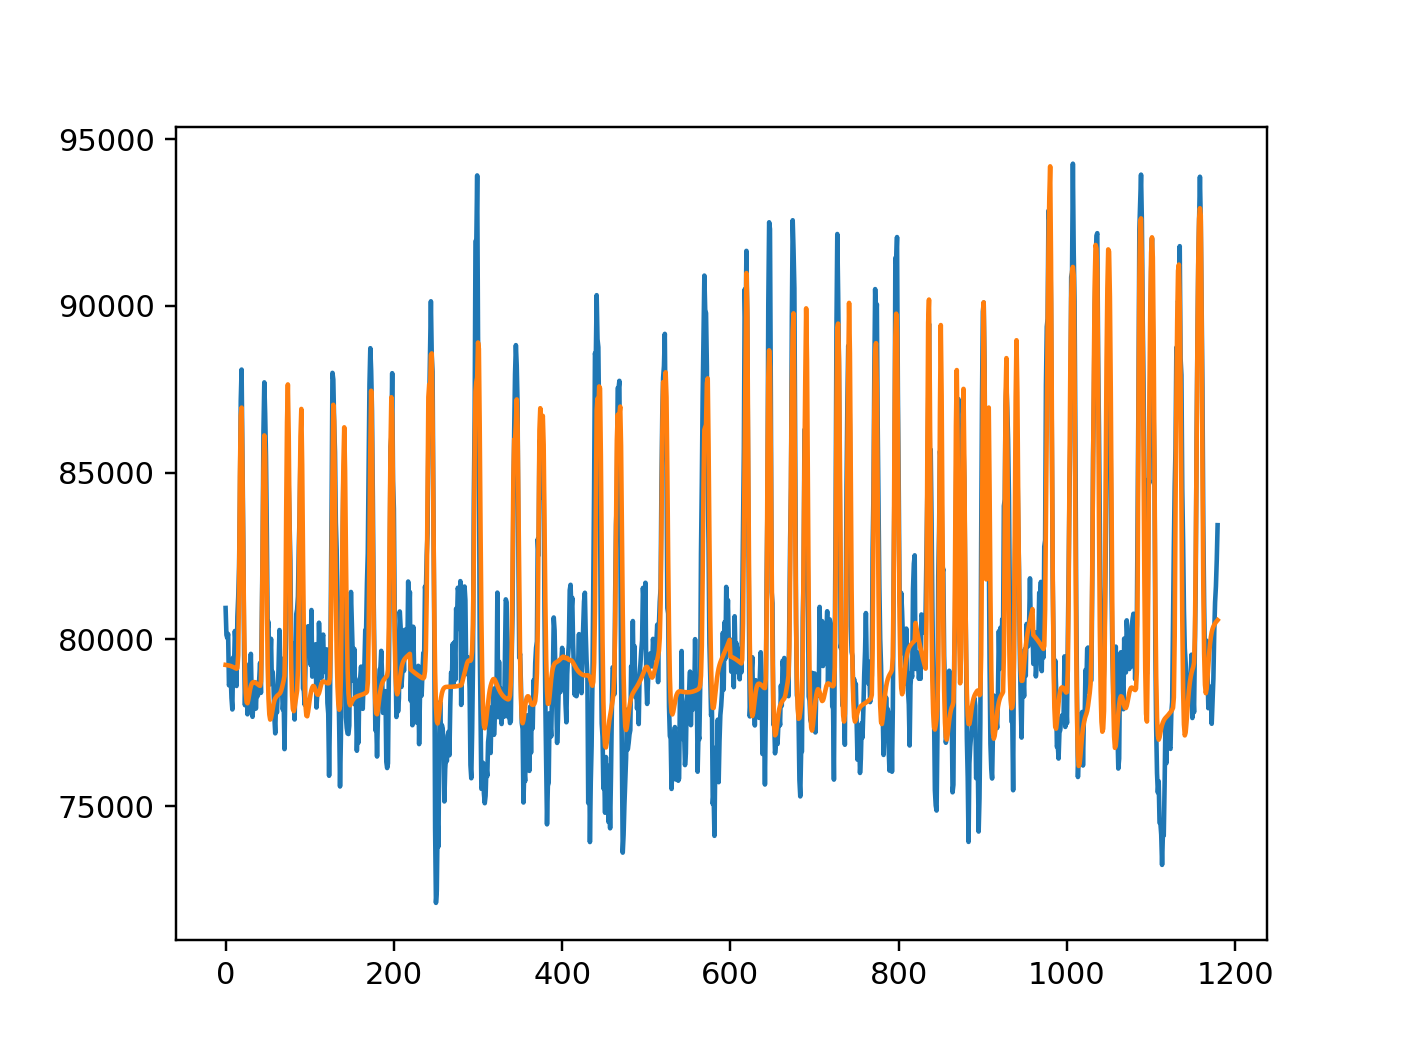

In [29]:
#current_result[np.where(gridsearch_params[:,-1]>0.66),:][0,0,:-1]
vox=6
fig=pl.figure()
pl.plot(timecourse_brain_nonzerovar[np.where(gridsearch_params[:,-1]>0.66),:][0,vox])
#pl.plot(gg_norm.return_single_prediction(*list(current_result[np.where(gridsearch_params[:,-1]>0.66),:][0,vox,:-1])))
pl.plot(gg_norm.return_single_prediction(*list(current_result_numerical[np.where(gridsearch_params[:,-1]>0.66),:][0,vox,:-1])))


<IPython.core.display.Javascript object>


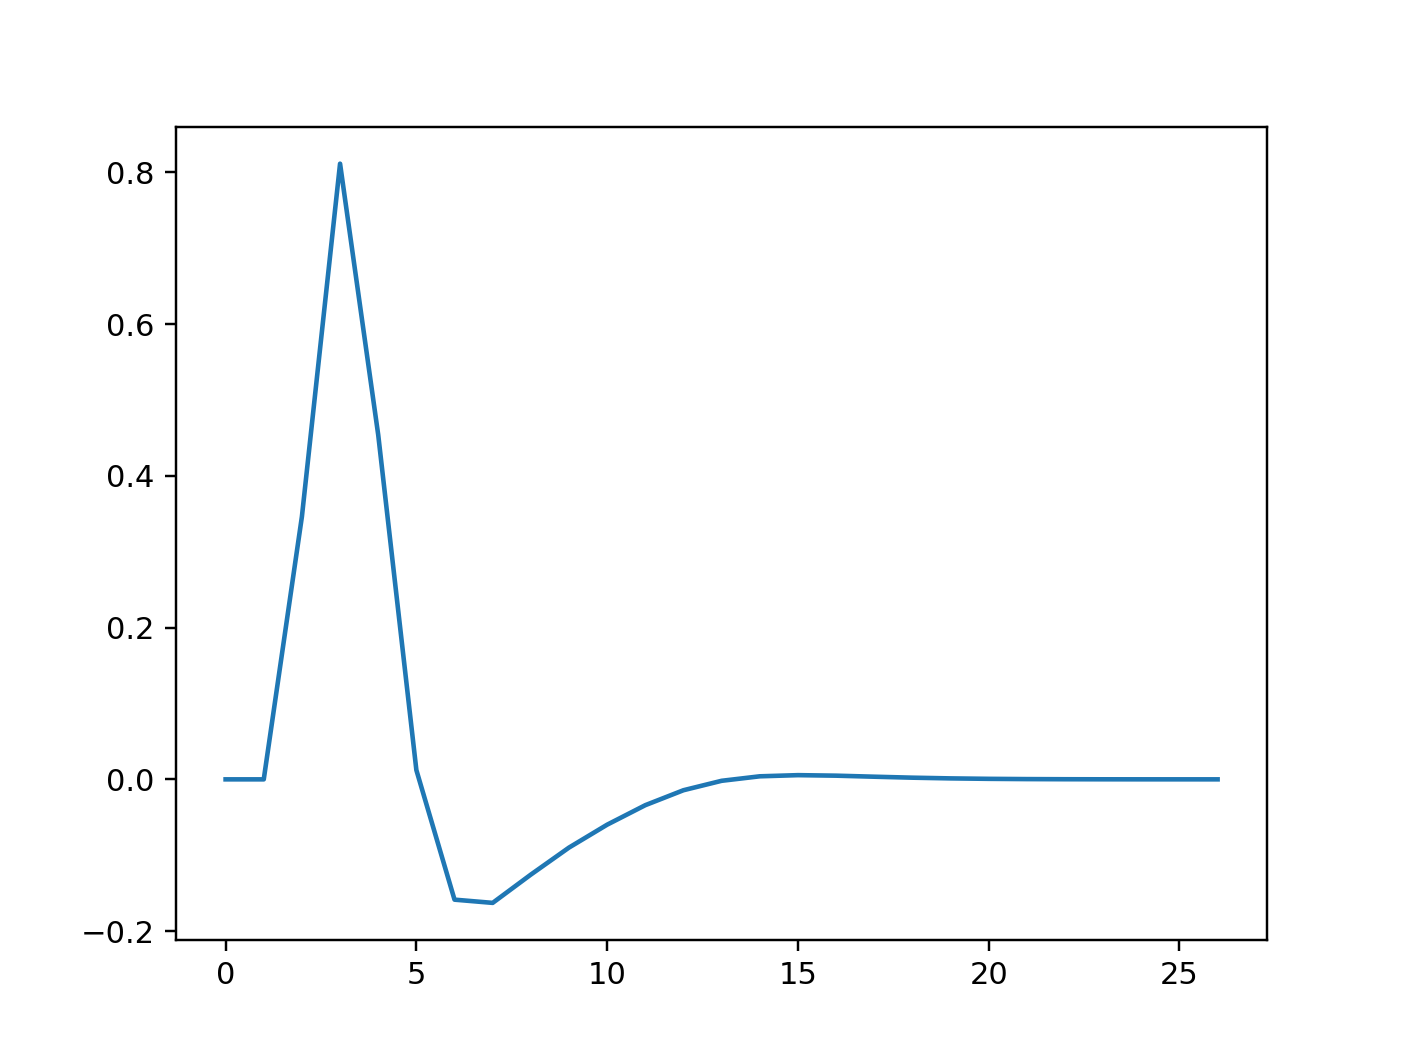

In [28]:
from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative

fig=pl.figure()

pl.plot(spm_hrf(tr=1.5, oversampling=1, time_length=40)+
       5*spm_time_derivative(tr=1.5, oversampling=1, time_length=40))

In [ ]:
%%time
#now refit dog model, starting from results of iterated Gaussian fitting
gg_dog = DoG_Iso2DGaussianGridder(stimulus=prf_stim,
                                   filter_predictions=True,
                                   window_length=window_length,
                                   cond_lengths=cond_lengths)
inf=np.inf
eps=1e-6 #to avoid dividing by zero

gf_dog = DoG_Iso2DGaussianFitter(data=timecourse_brain_nonzerovar,
                                   gridder=gg_dog,
                                   n_jobs=10,
                                   bounds=[(-10*n_pix,10*n_pix),  #x
                                           (-10*n_pix,10*n_pix),  #y
                                           (eps,10*n_pix),     #prf size
                                           (0,+inf),  #prf amplitude
                                           (0,+inf), #bold baseline
                                           (0,+inf),     #surround amplitude 
                                           (eps,10*n_pix)])     #surround size
                                     

starting_params = gf.gridsearch_params

gf_dog.iterative_fit(rsq_threshold=0.0, gridsearch_params=starting_params, verbose=True)

In [34]:
#compare rsq between models (ideally should be crossvalidated AIC or BIC)
rsq_mask=np.where(gf_norm.iterative_search_params[:,-1]>0.1)
print(np.mean(gf.gridsearch_params[gf.rsq_mask,-1]))
print(np.mean(gf.iterative_search_params[gf.rsq_mask,-1]))
print(np.mean(gf_norm.iterative_search_params[gf.rsq_mask,-1]))

0.24096577922649914
0.24490732239713542
0.2686311162490467


In [24]:
np.save('/Users/marcoaqil/PRFMapping/norm_bounded_iterparams_sub-001.npy', current_result)

In [50]:
#convert to ecc/polar and save results for plotting
ecc = np.sqrt(gf_norm.iterative_search_params[:,1]**2 + gf_norm.iterative_search_params[:,0]**2)
polar = np.arctan2(gf_norm.iterative_search_params[:,1], gf_norm.iterative_search_params[:,0])

polar[gf.rsq_mask]+=np.pi

attempt = np.zeros((final_mask.shape[0],final_mask.shape[1],final_mask.shape[2],10))
ha = attempt.reshape((-1,10))

combined_mask = np.ravel(np.var(timecourse_full_iso, axis=-1)>0) & np.ravel(final_mask)

ha[combined_mask,2:]=gf_norm.iterative_search_params[:,2:]
ha[combined_mask,0] = ecc
ha[combined_mask,1] = polar

haha = ha.reshape((final_mask.shape[0],final_mask.shape[1],final_mask.shape[2],10))


for i in range(0,10):
    nb.Nifti1Image(haha[:,:,:,i], timecoursefile_ses_1.affine).to_filename('norm_bounded{}.nii.gz'.format(i))


In [120]:
###old plotting cells

#print(timecourse_brain_nonzerovar.shape)
#a nice voxel for testing should be 185537
fig2=pl.figure()
pl.plot(timecourse_brain_nonzerovar[185537,:])
#pl.plot(sgfilter_predictions(timecourse_brain_nonzerovar[185537,:],
#                                            window_length=121))
#pl.plot(np.load('/Users/marcoaqil/PRFMapping/timecourse_brain_nonzerovar_sub-001.npy')[185537,:])

#print(np.min(gf.gridsearch_params[gf.rsq_mask,-1]))
#print(np.min(gf.iterative_search_params[gf.rsq_mask,-1]))
print(np.argmax(gf.gridsearch_params[np.where((gf.gridsearch_params[gf.rsq_mask,-1]<gf.iterative_search_params[gf.rsq_mask,-1])),-1]))
#combined_params = np.copy(gf.iterative_search_params)
#combined_params[np.where(gf.gridsearch_params[gf.rsq_mask,-1]>gf.iterative_search_params[gf.rsq_mask,-1])] = 
fig=pl.figure()

voxel_nr = 1716

print(gf.gridsearch_params[voxel_nr,-1])
print(gf.iterative_search_params[voxel_nr,-1])
#print(gf_norm.gridsearch_params[voxel_nr,-1])

pl.plot(np.load('/Users/marcoaqil/PRFMapping/timecourse_brain_nonzerovar_sub-001.npy')[voxel_nr,:])
pl.plot(gg.return_single_prediction(*list(gf.gridsearch_params[voxel_nr,:-1])))
pl.plot(gg.return_single_prediction(*list(gf.iterative_search_params[voxel_nr,:-1])))
#pl.plot(gg_norm.return_single_prediction(*list(gf_norm.iterative_search_params[voxel_nr,:-1])))
fig = pl.figure()
gg_norm.add_mean=True
pl.plot(gg_norm.return_single_prediction(*list(gf_norm.iterative_search_params[185537,:-1])))
pl.plot(sgfilter_predictions(timecourse_brain_nonzerovar[185537,:],
                                            window_length=121,add_mean=False)
       )

#print(np.argmax(gf.iterative_search_params[:,-1]))